<a href="https://colab.research.google.com/github/HiVivienne/MIT_Deep_Learning/blob/main/DeepSpiritedAway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

##READ ME

This notebook documents how we used recurrent neural network to generate music to mimic the distinct style of Joe Hisaishi, the famed Japanese composer behind many popular and critically acclaimed animated movies by Ghibli Studio such as Spirited Away, Princess Mononoke, and Castle in the Sky.

![picture](https://drive.google.com/uc?id=1KkcOUaT7fzKgSdynGLA6ADVd4NiDhw7a)


**What we did differently from the lab includes:**

1.   We trained our RNN on a custom dataset of Joe Hisaishi songs in the **MIDI format**.  The MIDI format covers a larger range of notes while also providing the capability of playing chords, something which the ABC format cannot handle.
2.   We use two LSTM layers to capture short range melodies and global harmonic patterns within the input training songs.

As a last step, we decided to select and edit the generated (using garage band, to be ) to manually put together a ~ 90 seconds song, to give the music a human touch. We hope this music brings you joy as Mr. Hisaishi's music does for us.

Here is a sample of what Mr. Hisaishi's music is usually like:




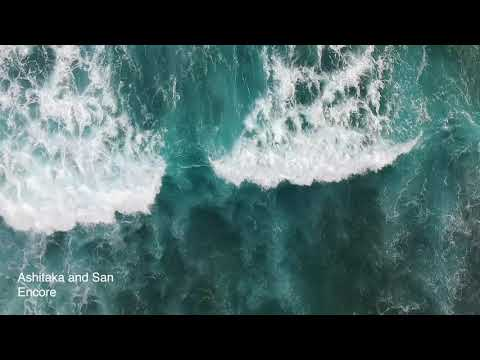

In [ ]:
import IPython
IPython.display.YouTubeVideo('0jZNKV5ROBM')


## Dependencies 
Install the dependencies for this script.

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

     |████████████████████████████████| 2.1MB 16.6MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp36-none-any.whl size=2115443 sha256=437deacbb124dc5079cda8397219f23444ad42e832a4f0a61c90ca4f9d691c3b
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


## Load the Dataset

Load our custom made dataset of Joe Hisaishi songs.  Unlike the lab, we don't train on songs in ABC format.  We instead train on songs in the MIDI format.  We decided to use MIDI because it captures a wider range of octaves while also allowing the model to not only learn to play single notes but chords also.

We use the music21 library to read in MIDI songs and then tokenize them to fed into the RNN.  A lot of the code used to manipulate MIDI files was borrowed from: https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

In [ ]:
# Install some libraries to work with MIDI files
!pip install music21
from music21 import converter, instrument, note, chord, stream

# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')

import glob

notes = []

start_indices = [0]

# Read in the files from the Joe Hisaishi dataset

# Remember to rename the directory when running this cell
for file in glob.glob("/content/gdrive/My Drive/midi_songs/*.mid"): 
  midi = converter.parse(file)
  notes_to_parse = None    
  parts = instrument.partitionByInstrument(midi)  

  # Parse the instrument parts to extract the notes
  if parts: 
      notes_to_parse = parts.parts[0].recurse()
  else: 
      notes_to_parse = midi.flat.notes    

  for element in notes_to_parse:
    if isinstance(element, note.Note):
        notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))

  # Separate the songs with a "\n\n"
  notes.append('\n')
  notes.append('\n')

  start_indices.append(len(notes))

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# A function that converts tokenized music to midi understable format
# Code borrowed from https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

def convertNotes2MIDI(prediction_output):
  offset = 0
  output_notes = []
  for pattern in prediction_output:
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)    # increase offset each iteration so that notes do not stack
    offset += 0.5

  return output_notes

# Function that converts back from notes to an output MIDI file

  def convertMIDI2audio(output_notes, filename='temp.mid'):
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)

In [ ]:
# Get the vocabulary

vocab = sorted(set(notes))
print("There are", len(vocab), "unique characters in the dataset")

There are 202 unique characters in the dataset


## Vectorize the song

We'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

Let's take a look at the numerical representation of the notes and chord in our dataset!

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '0' :   1,
  '0.2':   2,
  '0.2.4.7':   3,
  '0.2.5':   4,
  '0.2.6':   5,
  '0.2.7':   6,
  '0.3':   7,
  '0.3.7':   8,
  '0.4':   9,
  '0.4.6':  10,
  '0.4.7':  11,
  '0.5':  12,
  '0.6':  13,
  '1' :  14,
  '1.2':  15,
  '1.3':  16,
  '1.4':  17,
  '1.4.6':  18,
  '1.4.7':  19,
  ...
}


In [ ]:
### Vectorize the songs string ###

def vectorize_string(string):
  return np.array([char2idx[char] for char in string])

vectorized_songs = vectorize_string(notes)

We can also look at how a part of the text is mapped to an integer representation.  A note is represented as 'A2' for example, where 'A' represents the key and '2' represents the octave.  A chord on the other is represented as '9.11.2' to signify the keys that will be played together.

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(notes[100:110]), vectorized_songs[100:110]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

['9.1', 'A2', '9.1', 'E3', '9.1', 'A3', '9.1', 'E3', '9.11.2', 'G2'] ---- characters mapped to int ----> [129 136 129 176 129 137 129 176 133 196]


## Create training examples and targets


In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[start_idx: start_idx+seq_length] for start_idx in idx]
  '''construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[start_idx+1: start_idx+seq_length+1] for start_idx in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 159 ('C5')
  expected output: 139 ('A5')
Step   1
  input: 139 ('A5')
  expected output: 138 ('A4')
Step   2
  input: 138 ('A4')
  expected output: 159 ('C5')
Step   3
  input: 159 ('C5')
  expected output: 139 ('A5')
Step   4
  input: 139 ('A5')
  expected output: 148 ('B4')


## The Recurrent Neural Network (RNN) model

Our architecture is as illustrated below.  We built upon the model introduced in lecture.  **Instead of using a single LSTM layer we use two LSTMs in sequence.**  We did this in the hope that one LSTM could learn features corresponding to short range musical melodies while the other LSTM could use these features to learn long range dependencies.


![picture](https://drive.google.com/uc?id=175ZIfioL-PpyMWCZAsKOHBNYuVI_WoBj)

### Define the RNN model

Now, we will define a function that we will use to actually build the model.

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
    dropout=0.6
  )

In [ ]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units=rnn_units*2),

    LSTM(rnn_units=rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

## Training the model: loss and training operations

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model: 

In [ ]:
### Defining the loss function ###

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

## Hyperparameters for our Model

In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 64  # Experiment between 1 and 64
seq_length = 150  # Experiment between 50 and 500
learning_rate = 1e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 128
rnn_units = 512  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

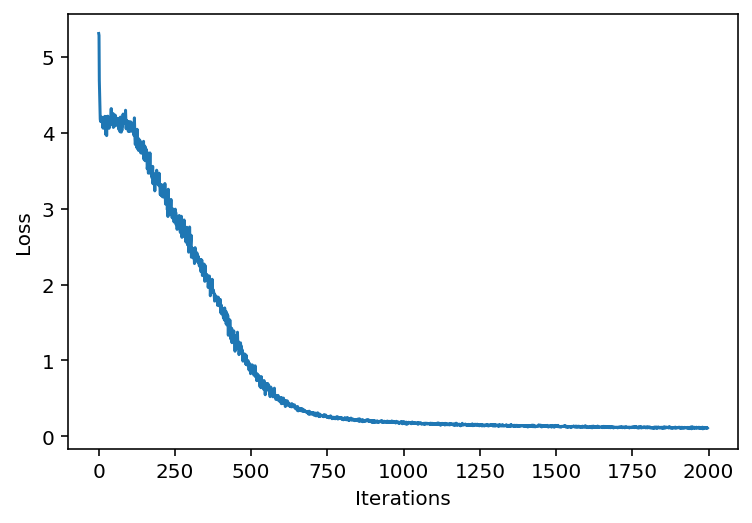

100%|██████████| 2000/2000 [05:29<00:00,  6.06it/s]


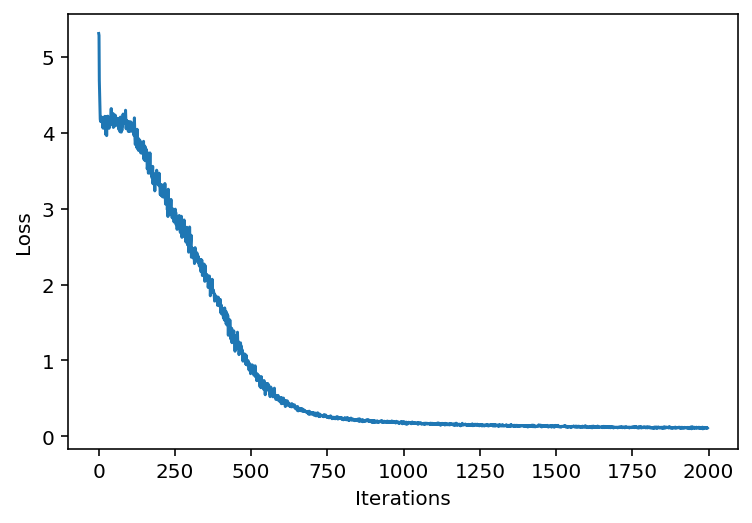

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


## Generate music using the RNN model


In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (1, None, 128)            25856     
_________________________________________________________________
lstm_32 (LSTM)               (1, None, 1024)           4722688   
_________________________________________________________________
lstm_33 (LSTM)               (1, None, 512)            3147776   
_________________________________________________________________
dense_16 (Dense)             (1, None, 202)            103626    
Total params: 7,999,946
Trainable params: 7,999,946
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[start_string]]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return [start_string] + text_generated

## Generate a New Song

We generate a new song by sampling a random starting note or chord from our vocabulary.  We then generate a new note/chord one at a time to create a song.

In [ ]:
import random

generated_text = generate_text(model, start_string=random.sample(vocab, 1)[0], generation_length=1000)

100%|██████████| 1000/1000 [00:07<00:00, 134.32it/s]


### Play back the generated music!

We can now call a function to convert the notes format text to a MIDI file.  You can play the MIDI files by downloading them.

In [ ]:
songs = [[]]
index = 0
for i in generated_text:
  if not i == '\n':
    songs[index].append(i)
  else:
    songs.append([])
    index += 1

for s in songs:
  if s == []:
    songs.remove(s)

for i in range(len(songs)):
  midi_notes = convertNotes2MIDI(songs[i])
  convertMIDI2audio(midi_notes, filename=str(i) + '.mid')